<h1>Interpolation Practice Notebook</h1>
<p>Let's recreate the WRF data plot (the 500 mb contours, filled contour with barbs) with NCEP Reanalysis Data, because the Reanalysis Data is regularly gridded.</p>

In [1]:
# If working with Azure Notebook don't forget to install your python packages\n",
%%bash
bash aznbsetup.sh


SyntaxError: invalid syntax (<ipython-input-1-159dc7e5ad2a>, line 2)

<p>First we need to download data for the u-winds, v-winds, wspds, and geopotential heights. These are 4D arrays with lats, lons, pressures and times. Data is available at https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.pressure.html, and we'll take the monthly mean data because it is already combined for each year.  You'll also need to find the wind speed data, we can do that by going to the bottom of the page and selecting item 4: Search the PSD products derived from the NCEP/NCAR Reanalysis including monthly and long-term means, then search for windspeed, which takes us here: <a href = "https://www.esrl.noaa.gov/psd/cgi-bin/db_search/DBSearch.pl?Dataset=CDC+Derived+NCEP+Reanalysis+Products+Other+Gaussian+Grid&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Pressure+Level&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Spectral&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Surface+Flux&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Surface+Level&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Tropopause+Level&Variable=Wind+Speed&group=1&submit=Search">windspeed</a>.  

Let's break this down: 
1. Open datasets and examine the data, figure out array sizes.
2. Figure out and perform interpolations (instantiate and evaluate).
3. Plot the data.
4. Create a for loop to use the same process to make many plots.


Handy reference for using the netCDF4 package: http://www.ceda.ac.uk/static/media/uploads/ncas-reading-2015/10_read_netcdf_python.pdf"

In [236]:
from netCDF4 import Dataset, num2date
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# 1. Open datasets and examine the data

# Open the NetCDF monthly mean air temperature file make sure your filename is correct!!!
nc_air = Dataset('air.mon.mean.nc') #netCDF4 package
ncxr_air = xr.open_dataset('air.mon.mean.nc') #xarray


# --------------------- NETCDF4 Package -------------------------- #
# Here are some useful commands for netCDF4 objects
#print(nc_air.dimensions.keys())
print(nc_air.variables.keys())

# Creating a functional datetime object
#print(nc_air.variables['time'].units)
t_unit = nc_air.variables['time'].units

try :
    t_cal = nc_air.variables['time'].calendar

except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

nc_times = nc_air.variables['time'][:]

times_nc = []
times_nc.append(num2date(nc_times,units = t_unit,calendar = t_cal))

# Creating an array with the air data
air_nc = nc_air['air'][:]


# --------------------- Xarray Package -------------------------- #
# Here are some useful commands for xarray objects, notice the difference in times!! 
# Type the times for netCDF4 and xarray, and choose how you want to handle times.
# This is a great reference for numpy datetimes https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.datetime.html

#print(ncxr_air.keys())
#print(ncxr_air.time.values)
#print(ncxr_air.air.values)
air_xr = ncxr_air['air'][:].values  #Type this, what is the big difference between packages?

# Is there a difference between the date loaded in from xarray and netcdf? Here's a test:
#print(air_xr - air_nc) 

# Sometimes differences exist due to different methods of storing data
# and how the package interprets the data when opening the file.  It is always good to check.


# If you haven't already done so, it would be good to figure out the size of 
# the air temperature data array.




# Now we want to load in pressure, geopotential height, and wind variables 
# like the WRF plotting example, so load all of your data. You can choose whether
# to use netCDF4 or xarray.




# After you load lots of data into your memory, best not to keep reloading the cell... 
# open a new cell to test the array sizes, units etc.


odict_keys(['level', 'lat', 'lon', 'time', 'air'])


In [101]:
# Best to confirm the data are all the same array size! Might want to check units, 
# lats and lons, pressures (level), etc. 
# For units try (ncdataset_name['vwnd'][:].units)


# Find out this information!
# Size of arrays
# Units of level
# Units of winds
# Units of hgts
# lat and lon min/max
# Units/datatype for datetimes


# Note that the levels are not in a regular grid!! This means that we should either 
# regularize the grid, or since we want the 500 mb levels, we'll just select out the data
# we want. Prove to your self that the below command (air500 = ...) selects the 500 mb heights.

air500 = air_xr[:,5,:,:]


# The following code is very important if you want to use the datetime64 from xarray.  
# We need a way to convert to float types in order to do interpolations.

times = (ncxr_air['time'][:] - ncxr_air['time'][0])/np.timedelta64(1, 's')

(838, 73, 144)


In [190]:
# 2A. Instantiation of our interpolation!
# Interpolation Time Again - 4D Style!! Hours since 1800 seem good now, don't they?
# You should know that the array is in times, levels, lats, lons

from interpolation.splines import LinearSpline, CubicSpline
a = np.array([min(times),90.0,0.0])         # Remember that latitudes start at 90 (North) and go to -90 (South)
b = np.array([max(times),-90.0,357.5])      # 
orders = np.array([838,73,144])             # Here we match the dimensions of our data

# multilinear
lin = LinearSpline(a,b,orders,air500)

# cubic
spline = CubicSpline(a,b,orders,air500) # filter the coefficients



Setting
[838  73 144]
(838, 73, 144)


In [270]:
# 2B. Evaluation of interpolation!  Now is the fun part of deciding coordinates and times.
# What were the pressure levels like on the day of my birth, Nov. 20 1978, 40.7608° N and 111.8910° W
# For converting longitudes W means negative, and we want to have the prime meridan at zero, 
# so we add 360 to -111.8910.

birthday = (np.datetime64('1978-11-20') - ncxr_air['time'][0])/np.timedelta64(1, 's')

slc_lat = 40.7608
slc_lon = -111.8910 + 360.

S = np.array([birthday,500,slc_lat,slc_lon])

# But let's make a grid around slc...
slc_lats = np.linspace(slc_lat + 5., slc_lat - 5., 100)
slc_lons = np.linspace(slc_lon - 5., slc_lon + 5., 100)

slc_times = np.linspace(birthday - 5*24*3600, birthday + 5*24*3600, 11)

points_x, points_y, points_z = np.broadcast_arrays(slc_times.reshape(-1,1,1), slc_lats.reshape(1,-1,1), slc_lons)
slc_points = np.vstack((points_x.flatten(),
                    points_y.flatten(),
                    points_z.flatten()
                  )).T

interp = spline(slc_points).reshape(slc_times.size,slc_lats.size,slc_lons.size)

#Converting times back to datetime64
interp_times = num2date(slc_times,units = 'seconds since 1948-01-01 00:00:0.0',calendar = t_cal)


#Making an xarray object of interpolated data
ds = xr.Dataset()
ds['air'] = (('time','x', 'y'), interp)
ds.coords['lat'] = (('x'), slc_lats)
ds.coords['lon'] = (('y'), slc_lons)
ds.coords['time'] = pd.date_range('1978-11-15', periods=11)
ds.coords['reference_time'] = pd.Timestamp('1948-01-01')

ds

<xarray.Dataset>
Dimensions:         (time: 11, x: 100, y: 100)
Coordinates:
    lat             (x) float64 45.76 45.66 45.56 45.46 45.36 45.26 45.15 ...
    lon             (y) float64 243.1 243.2 243.3 243.4 243.5 243.6 243.7 ...
  * time            (time) datetime64[ns] 1978-11-15 1978-11-16 1978-11-17 ...
    reference_time  datetime64[ns] 1948-01-01
Dimensions without coordinates: x, y
Data variables:
    air             (time, x, y) float64 -24.82 -24.84 -24.87 -24.9 -24.92 ...

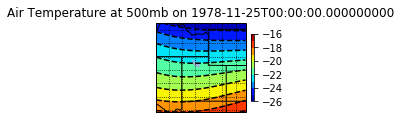

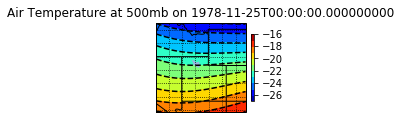

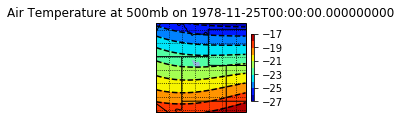

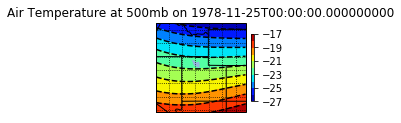

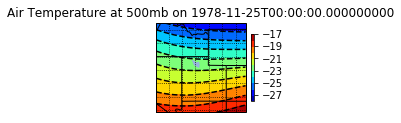

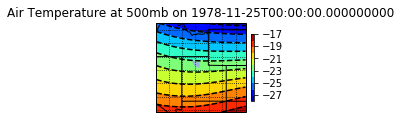

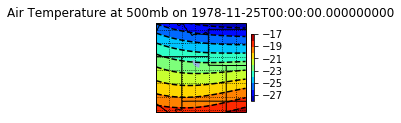

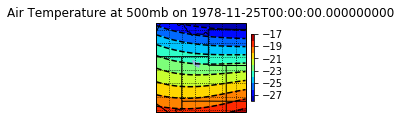

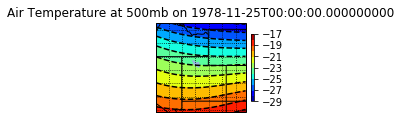

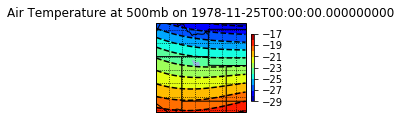

In [298]:
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as feat
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords

# 3. Make one plot
# Get the latitude and longitude points
lats = ds['lat'].values
lons = ds['lon'].values
vals = ds['air'].values

# Create a figure
n = 10
for i in range(n):

    fig = plt.figure(figsize=(2,2))
    plt.subplot(1,n+1,i+1)

    # Set the GeoAxes to the PlateCarree
    ax = plt.axes(projection=crs.PlateCarree(central_longitude=slc_lon, globe=None))

    # Make the contour outlines and filled contours for the smoothed sea level pressure.

    plt.contour(lons, lats, vals[i,:,:], 10, colors="black",
            transform=crs.PlateCarree())
    plt.contourf(lons, lats, vals[i,:,:], 10, transform=crs.PlateCarree(),
            cmap=get_cmap("jet"))

    #Download State Boundaries
    state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                        name='admin_1_states_provinces_lines',
                                        scale='110m', facecolor='none')
    ax.coastlines('50m', linewidth=0.8)
    ax.add_feature(feat.BORDERS, zorder=1)
    ax.add_feature(feat.LAKES, zorder=1)
    ax.add_feature(state_boundaries, edgecolor='black',zorder=1)
    ax.gridlines(color="black", linestyle="dotted")
    plt.title("Air Temperature at 500mb on {}".format(ds['time'].values[n]))
    plt.colorbar(ax=ax, shrink=.62)   

plt.show()

In [ ]:
# 4. Turn one plot into a loop for multiple interpolations based on the
# dates times, and places (and levels) you want!